<a href="https://colab.research.google.com/github/Aru-14/AICTE_Internship_Garbage_Collection/blob/main/Week%201/GarbageCollection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr



In [4]:
dataset_dir=r"/content/drive/MyDrive/TrashType_Image_Dataset"
image_size = (224,224)
batch_size = 32
seed= 42

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
val_class = val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take(val_batches // 5)
val_dat = val_ds.skip(val_batches // 5)

test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [8]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


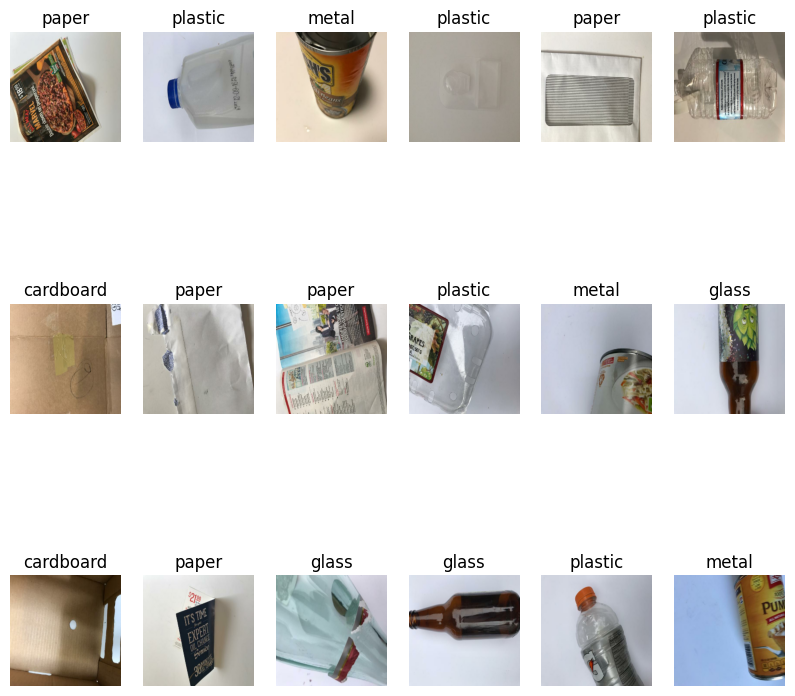

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(2):
  for i in range(18):
    ax = plt.subplot(3,6,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


In [10]:
def count_distribution(dataset, class_names):
  total = 0
  counts = {name: 0 for name in class_names}

  for _, labels in dataset:
    for label in labels.numpy():
      class_name = class_names[int(label)]
      counts[class_name] += 1
      total += 1

  for k in counts:
    counts[k] = round((counts[k]/total)*100,2)

  return counts

In [11]:
def simple_bar_plot(dist, title):
  plt.bar(dist.keys(), dist.values(), color = "salmon")
  plt.title(title)
  plt.ylabel('Percentage (%)')
  plt.xticks(rotation = 50)
  plt.ylim(0, 100)
  plt.tight_layout()
  plt.show()

In [12]:
class_names = train_ds.class_names

train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
  overall_dist[k] = round((train_dist[k] + val_dist[k])/2,2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 9.38, 'glass': 21.88, 'metal': 20.83, 'paper': 26.04, 'plastic': 18.75, 'trash': 3.12}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


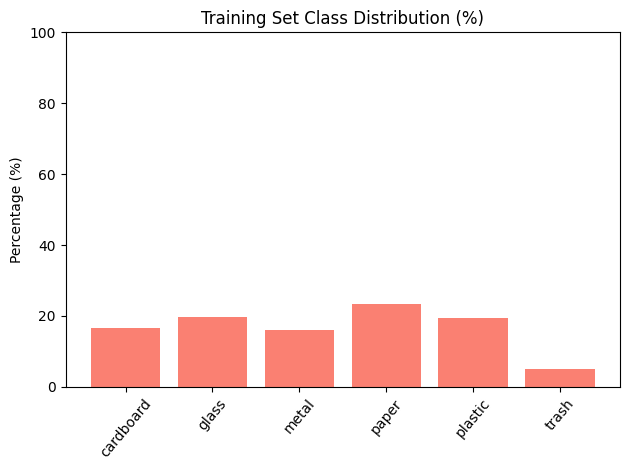

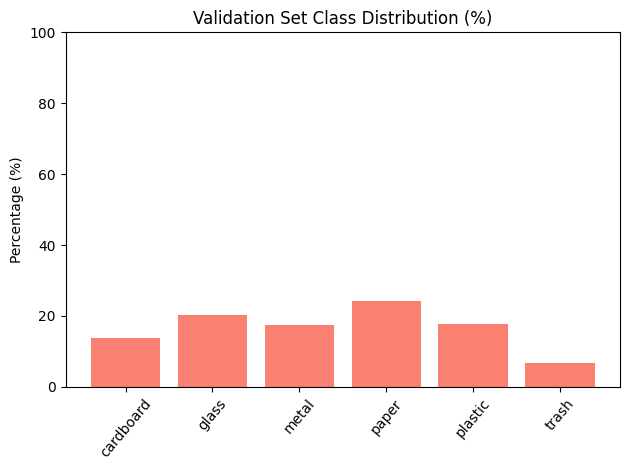

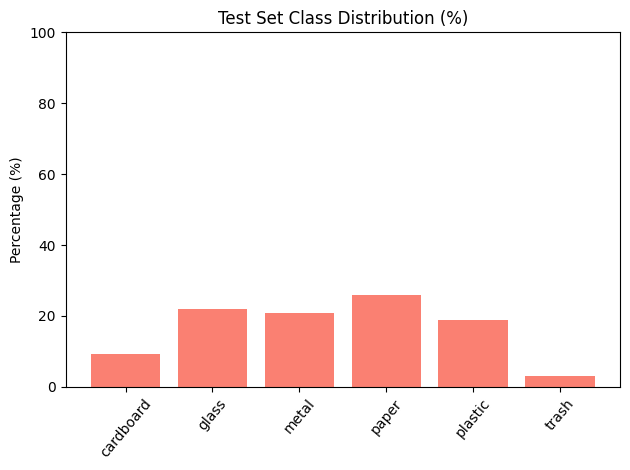

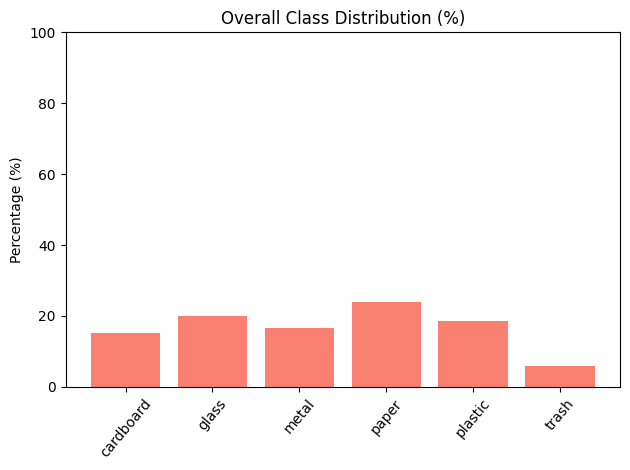

In [13]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [14]:
class_counts = {i:0 for i in range(len(class_names))}
all_labels=[]

for images, labels in train_ds:
  for label in labels.numpy():
    class_counts[int(label)] += 1
    all_labels.append(int(label))

class_weights_array = compute_class_weight(
    class_weight = "balanced",
    classes = np.arange(len(class_names)),
    y = all_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [15]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2)
])

In [16]:
base_model = EfficientNetV2B2(include_top= False, input_shape=(224,224,3),include_preprocessing=True, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model = Sequential([
    layers.Input(shape=(224,224,3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

In [18]:
model.compile(
    optimizer = optimizers.Adam(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [19]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 3,
    restore_best_weights=True

)

In [20]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    class_weight = class_weights,
    callbacks = [early]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 372ms/step - accuracy: 0.2149 - loss: 1.7971 - val_accuracy: 0.2871 - val_loss: 1.7031
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.3032 - loss: 1.7198 - val_accuracy: 0.4059 - val_loss: 1.6069
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.3972 - loss: 1.6021 - val_accuracy: 0.5030 - val_loss: 1.5030
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - accuracy: 0.4667 - loss: 1.4849 - val_accuracy: 0.5703 - val_loss: 1.4141
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step - accuracy: 0.5261 - loss: 1.4120 - val_accuracy: 0.6059 - val_loss: 1.3332
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step - accuracy: 0.5869 - loss: 1.3190 - val_accuracy: 0.6495 - val_loss: 1.2370
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 292ms/step - accuracy: 0.6172 - loss: 1.2394 - val_accuracy: 0.6594 - val_loss: 1.1685
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.6583 - loss: 1.1502 - val_accu

In [21]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [22]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

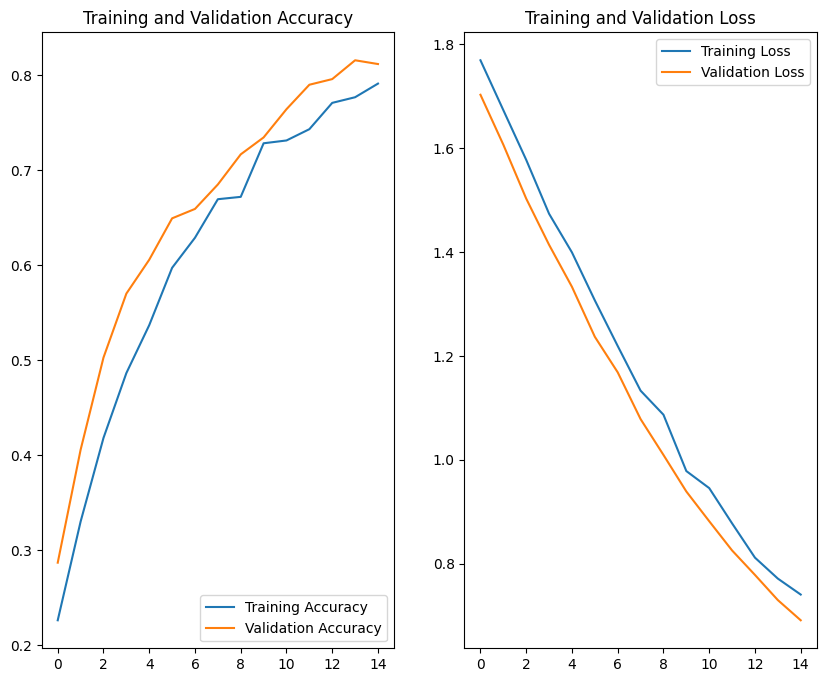

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range=range(len(acc))

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
loss, accuracy = model.evaluate(test_ds_eval)
print('Test accuracy :', accuracy, 'Test loss is:', loss)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8229 - loss: 0.7295
Test accuracy : 0.8020833134651184 Test loss is: 0.7599143385887146


In [25]:
y_true = np.concatenate([y.numpy() for x,y in test_ds_eval], axis=0)

y_pred_probs = model.predict(test_ds_eval)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(cm)
print(classification_report(y_true, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step
[[ 8  0  0  3  0  1]
 [ 0 18  0  0  2  0]
 [ 0  1 12  0  0  1]
 [ 3  0  0 20  0  1]
 [ 0  1  0  0 14  1]
 [ 0  2  1  2  0  5]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.82      0.90      0.86        20
           2       0.92      0.86      0.89        14
           3       0.80      0.83      0.82        24
           4       0.88      0.88      0.88        16
           5       0.56      0.50      0.53        10

    accuracy                           0.80        96
   macro avg       0.78      0.77      0.78        96
weighted avg       0.80      0.80      0.80        96



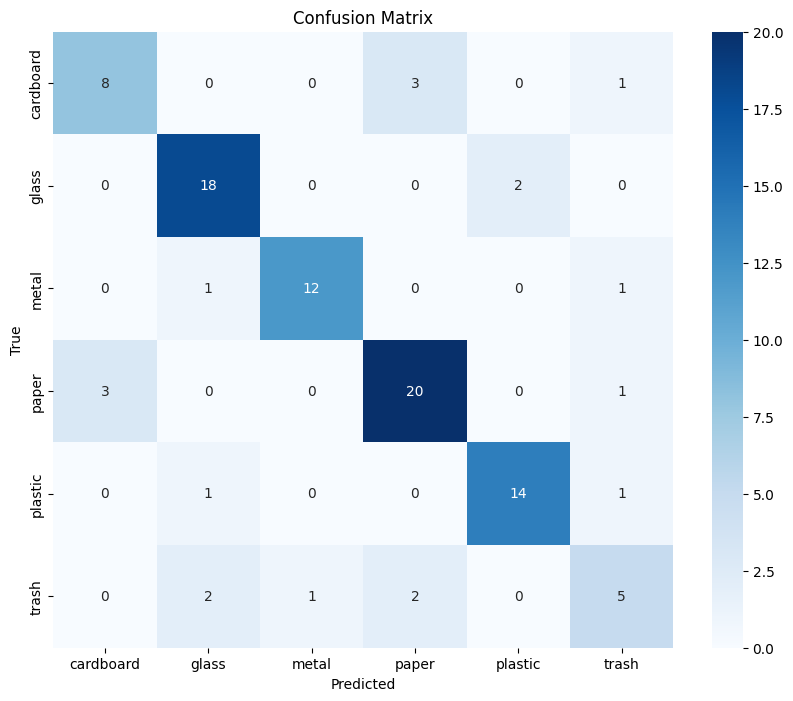

In [26]:
plt.figure(figsize=(10,8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


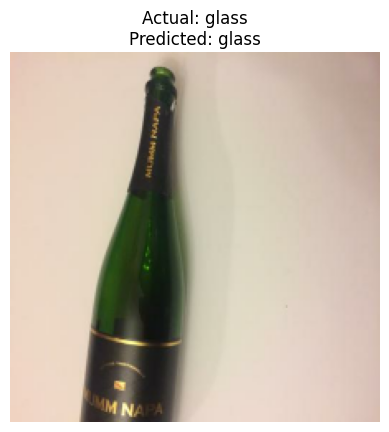

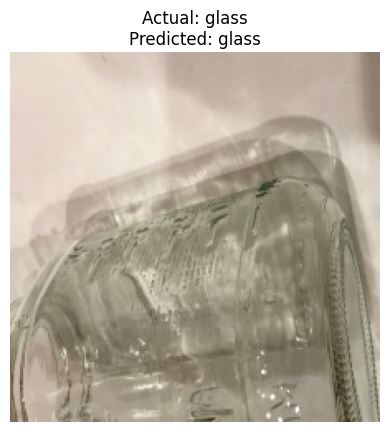

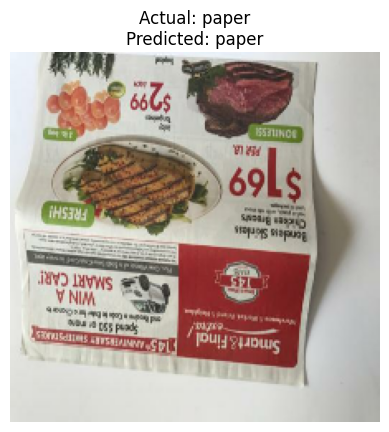

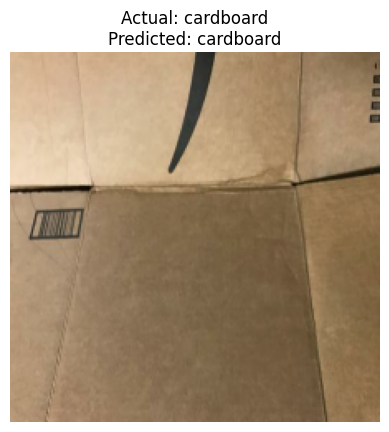

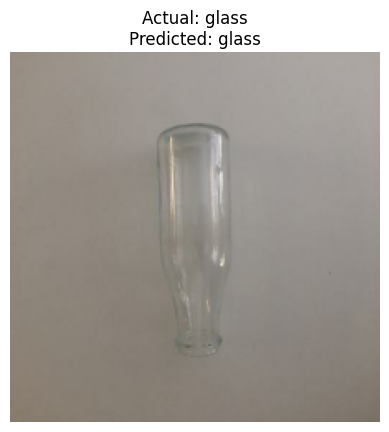

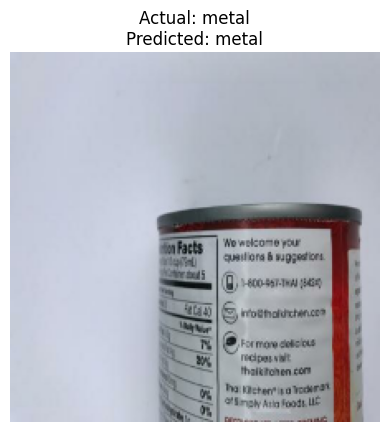

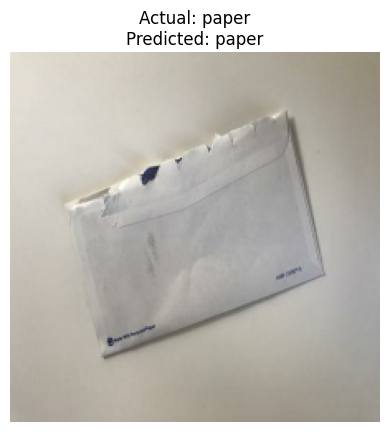

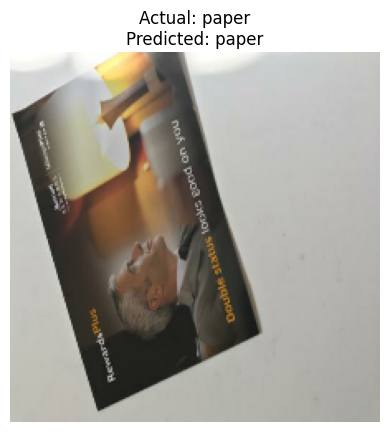

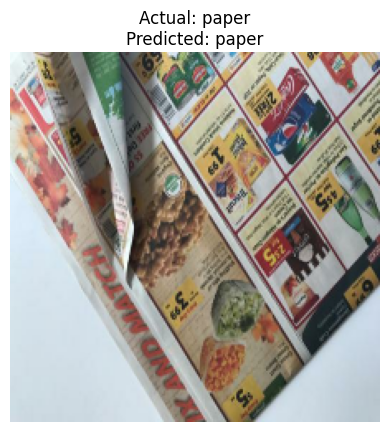

In [27]:
class_names = train_ds.class_names

for images, labels in test_ds_eval.take(1):
  predictions = model.predict(images)
  pred_labels = tf.argmax(predictions, axis=1)

  for i in range(9):

    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[pred_labels[i]]}")
    plt.axis("off")
    plt.show()

In [38]:
model.save("model.h5")


In [39]:
pip install streamlit


In [40]:
!pip install -q streamlit
!npm install -g localtunnel



⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
changed 22 packages in 2s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

In [52]:
%%writefile app.py
import streamlit as st
from PIL import Image
import tensorflow as tf
import numpy as np

# Load model
model = tf.keras.models.load_model("model.h5")
IMG_SIZE = (224, 224)

# Class names from train_ds.class_names
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

st.title("Garbage Classifier")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded image", use_container_width=True)

    image = image.resize(IMG_SIZE)
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=0)

    prediction = model.predict(image_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    st.write(f"This is a {predicted_class}")
    st.write(f"Confidence: {confidence * 100:.2f}%")



Overwriting app.py


In [53]:
!streamlit run app.py & npx localtunnel --port 8501




⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.19.17.111:8501

your url is: https://stupid-files-wash.loca.lt
2025-06-25 04:42:39.824085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750826559.866294   19840 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750826559.878012   19840 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 04:42:44.003525: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value wa